In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import signal
from sklearn.preprocessing import minmax_scale
from scipy.signal import resample
import heartpy as hp
import warnings
warnings.filterwarnings('ignore')

In [2]:
source_dir = 'D:/Dropbox/resample/'
output_dir = 'D:/Dropbox/re/'

rawdata_list = os.listdir(source_dir)
print(len(rawdata_list))

654


In [3]:
def get_difference_list(seq):
    seq  = np.concatenate([[0], seq, [0]])
    differ = seq[1:] - seq[:-1]
    differ = differ[1:-1]
    return differ

In [5]:
def check_ppg_abnormal(ppg, sig_length, fs):
    if np.mean(ppg)>=1:
        ppg = ppg/4

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) 
    except Exception:
        return {'result': 0, 'reason': 'heartpy 사용중 error'}

    # Peak
    pks_PPG = wd_p['peaklist']  # peak location list
    pks_PPG = np.array(pks_PPG)

    if pks_PPG[-1] == (sig_length-1):
        pks_PPG = np.delete(pks_PPG,-1)

    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  

    if all(np.gradient(PPG[-3:])>=0):
        val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)


    peak_dist_PPG = get_difference_list(pks_PPG)  # Interval between peaks
    std_peak_dist_PPG = np.std(peak_dist_PPG)     # feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG])          # feature 2
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # feature 3
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks))      # feature 4


    # peak 값들이 고르지 않거나, peak 간격이 고르지 않거나, peak 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_peaks_PPG > 0.15):
        return {'result': 1, 'reason': 'peak들의 std가 0.15 초과'}
    if (std_peak_dist_PPG > 14):
        return {'result': 1, 'reason': 'peak간격의 std가 14 초과'}
    if (max_min_differ_pks > 0.53):
        return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.53 초과'}
    if (max_differ_pks > 0.39):
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.39 초과'}
    

    if (np.any(peak_dist_PPG<15)):
        return {'result': 0, 'reason': 'peak간 거리가 너무 가까움'}


    # valley
    valley_dist_PPG = get_difference_list(val_PPG)  # Interval between valleys
    std_valley_dist_PPG = np.std(valley_dist_PPG)   # feature 5
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # feature 6
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val))        # vfeature 7


    if (std_valley_dist_PPG > 38):
        return {'result': 1, 'reason': 'valley간격의 std가 38 초과'}
    if (max_min_differ_val > 0.53):
        return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.53 초과'}
    if (max_differ_val > 0.39):
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.39 초과'}

    return {'result': 0, 'reason': '정상'}

In [3]:
time_len = 25

fs0 = 125 # Before change sampling rate
fs1 = 100 # After change sampling rate
intv = fs0 * time_len # segment length / (sampling rate)*(seconds)

In [7]:
file_num = len(rawdata_list)
total_data_num = 0

for idx, p in enumerate(rawdata_list):   # range(len(rawdata_list)):

    wf_dic = dict()
    wf_dic['ART'] = list()
    wf_dic['PLETH'] = list()
    data_num = 0 

    data = np.load(source_dir + p, allow_pickle=True) # raw_signal_load
    rec_nb = len(data['ART'])                         # number of records for one patient
    print(f'checking ({idx+1}/{file_num})th file, rec_num: {rec_nb}')

    for i in range(rec_nb):
        print(f'({idx+1}/{file_num})file-({i+1}/{rec_nb})rec.')
    
        ppgf1 = data['PLETH'][i][2500:3250]
        ppgf2 = data['PLETH'][i][3250:]
    
        if check_ppg_abnormal(ppgf1, sig_length=750, fs=100)['result'] == 0 and check_ppg_abnormal(ppgf2, sig_length=750, fs=100)['result'] == 0:
            continue

        wf_dic['ART'].append(data['ART'][i])
        wf_dic['PLETH'].append(data['PLETH'][i])
        data_num+=1

    if len(wf_dic['PLETH']) != 0:
        np.savez_compressed(output_dir + 'resampleSet' + str(idx+1), **wf_dic)
    total_data_num+=data_num
    print(f'{data_num} data from {idx+1}th file. total data: {total_data_num}')
    del wf_dic

checking (1/654)th file, rec_num: 10
(1/654)file-(1/10)rec.
(1/654)file-(2/10)rec.
(1/654)file-(3/10)rec.
(1/654)file-(4/10)rec.
(1/654)file-(5/10)rec.
(1/654)file-(6/10)rec.
(1/654)file-(7/10)rec.
(1/654)file-(8/10)rec.
(1/654)file-(9/10)rec.
(1/654)file-(10/10)rec.
9 data from 1th file. total data: 9
checking (2/654)th file, rec_num: 27
(2/654)file-(1/27)rec.
(2/654)file-(2/27)rec.
(2/654)file-(3/27)rec.
(2/654)file-(4/27)rec.
(2/654)file-(5/27)rec.
(2/654)file-(6/27)rec.
(2/654)file-(7/27)rec.
(2/654)file-(8/27)rec.
(2/654)file-(9/27)rec.
(2/654)file-(10/27)rec.
(2/654)file-(11/27)rec.
(2/654)file-(12/27)rec.
(2/654)file-(13/27)rec.
(2/654)file-(14/27)rec.
(2/654)file-(15/27)rec.
(2/654)file-(16/27)rec.
(2/654)file-(17/27)rec.
(2/654)file-(18/27)rec.
(2/654)file-(19/27)rec.
(2/654)file-(20/27)rec.
(2/654)file-(21/27)rec.
(2/654)file-(22/27)rec.
(2/654)file-(23/27)rec.
(2/654)file-(24/27)rec.
(2/654)file-(25/27)rec.
(2/654)file-(26/27)rec.
(2/654)file-(27/27)rec.
23 data from 2th fil

Checking the result

In [12]:
s = 210
data = np.load(output_dir + 'resampleSet'+str(s)+'.npz', allow_pickle=True)
print(data['PLETH'].shape)

(5, 4000)


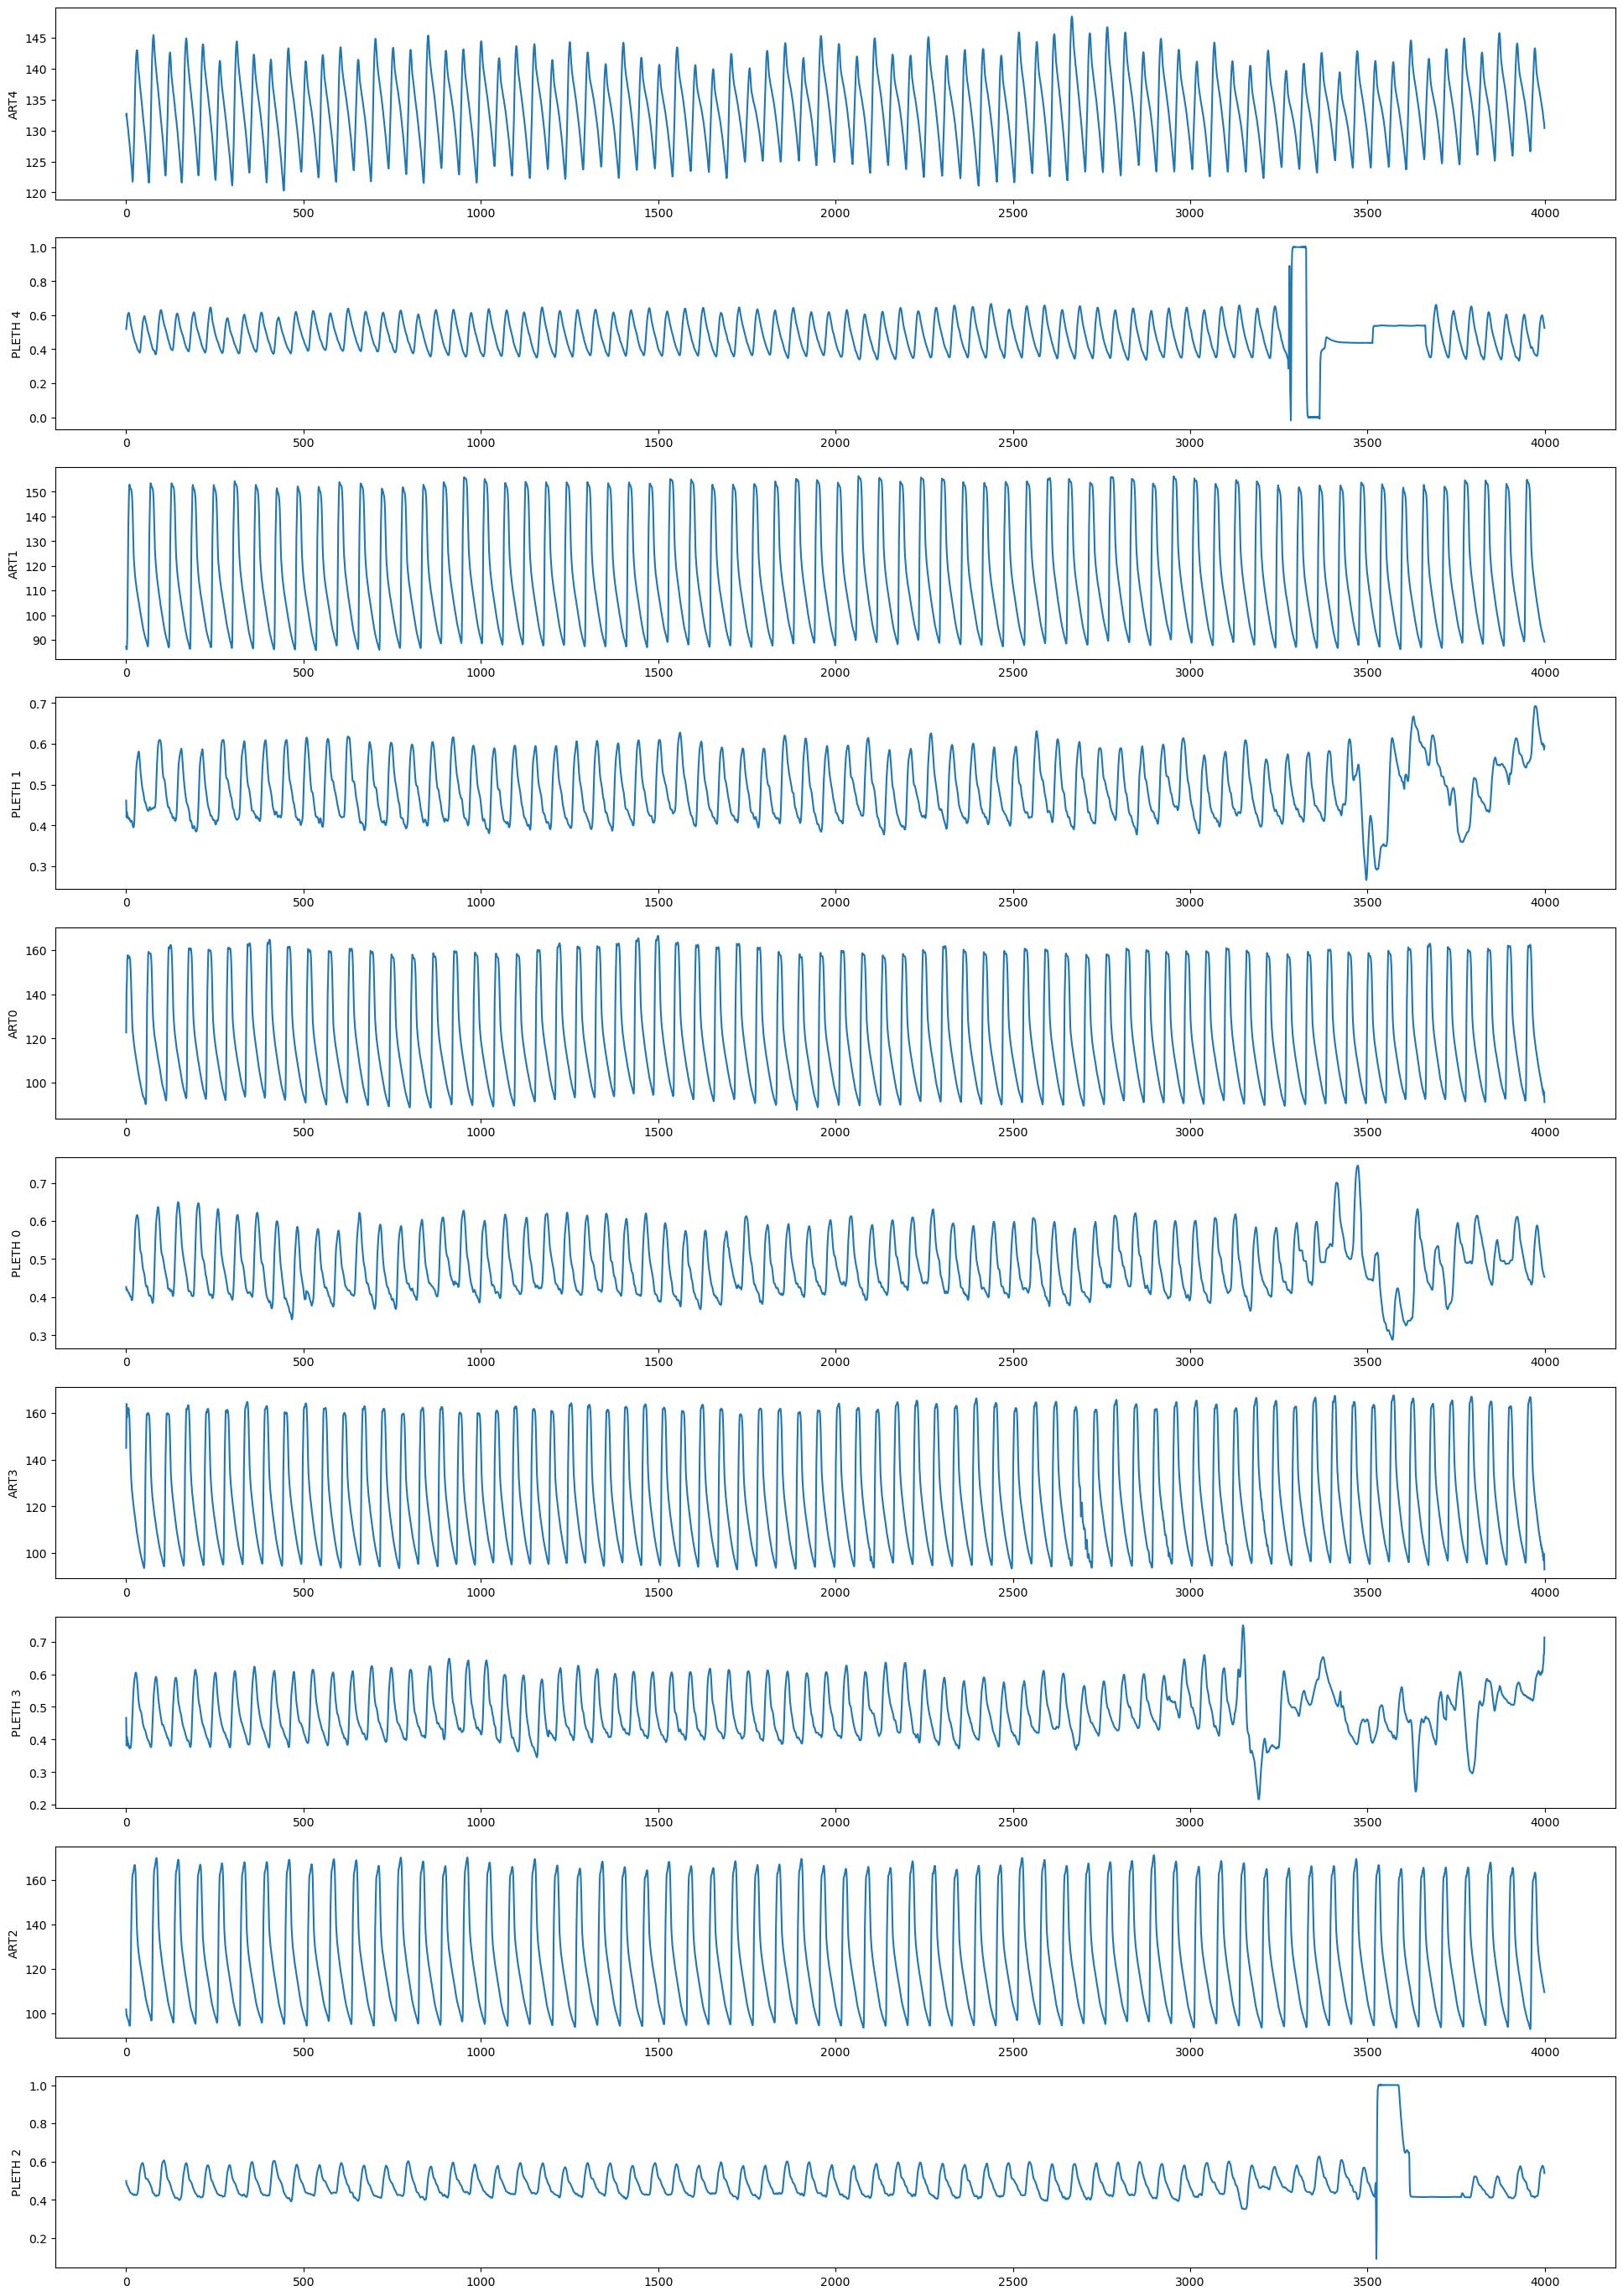

In [13]:
import random as rd
randomID=[]                        

for i in range(5):
    a = rd.randrange(0,len(data['PLETH']))       
    while a in randomID:              
        a = rd.randint(0,len(data['PLETH']))
    randomID.append(a) 

plt.figure(figsize=(24,35))

for i in range(5):
    plt.subplot(10,1,2*i+1)
    plt.plot(data['ART'][randomID[i]])
    plt.ylabel('ART'+ str(randomID[i]))

    plt.subplot(10,1,2*i+2)
    plt.plot(data['PLETH'][randomID[i]])
    plt.ylabel('PLETH '+ str(randomID[i]))

plt.show()

Below is the code to check the results  
It doesn't matter if you don't run it

(37, 4000)
{'result': 0, 'reason': '정상'}
{'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.37 초과'}


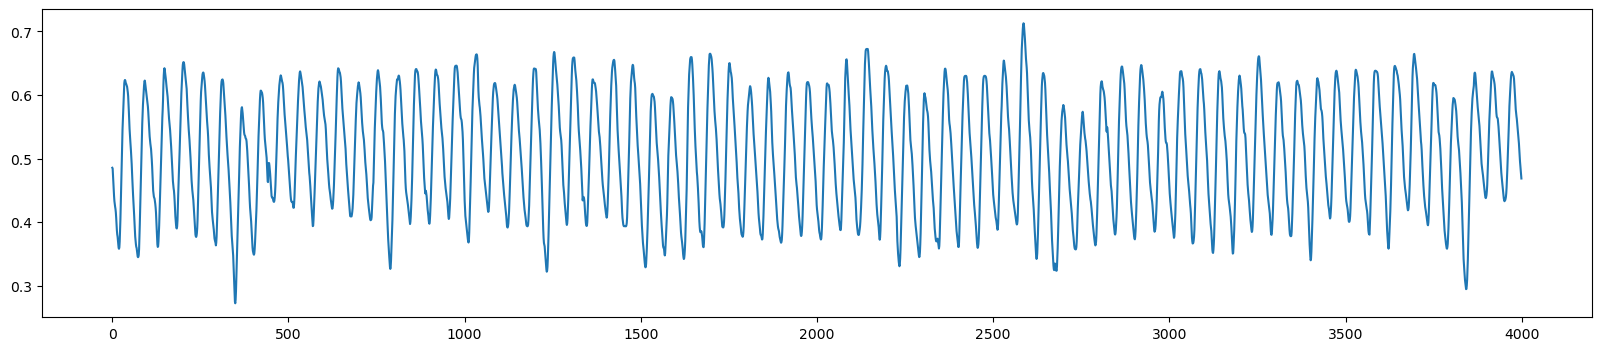

In [88]:
dataID = 12
data = np.load(output_dir + 'resampleSet'+str(s)+'.npz', allow_pickle=True)
print(data['PLETH'].shape)

print(check_ppg_abnormal(data['PLETH'][dataID][2500:3250], sig_length=750, fs=100))
print(check_ppg_abnormal(data['PLETH'][dataID][3250:], sig_length=750, fs=100))

plt.figure(figsize=(20,4))
plt.plot(data['PLETH'][dataID])
plt.show()

std_peak_dist_PPG: 2.7028791233711424
std_peaks_PPG: 0.04264295789930789
max_min_differ_pks: 0.18763288412164925
max_differ_pks: 0.12334188173130656
std_valley_dist_PPG: 1.4431370787625042
std_valley_PPG: 0.10651489953095941
max_min_differ_val: 0.38695675184998823
max_differ_val: 0.38695675184998823


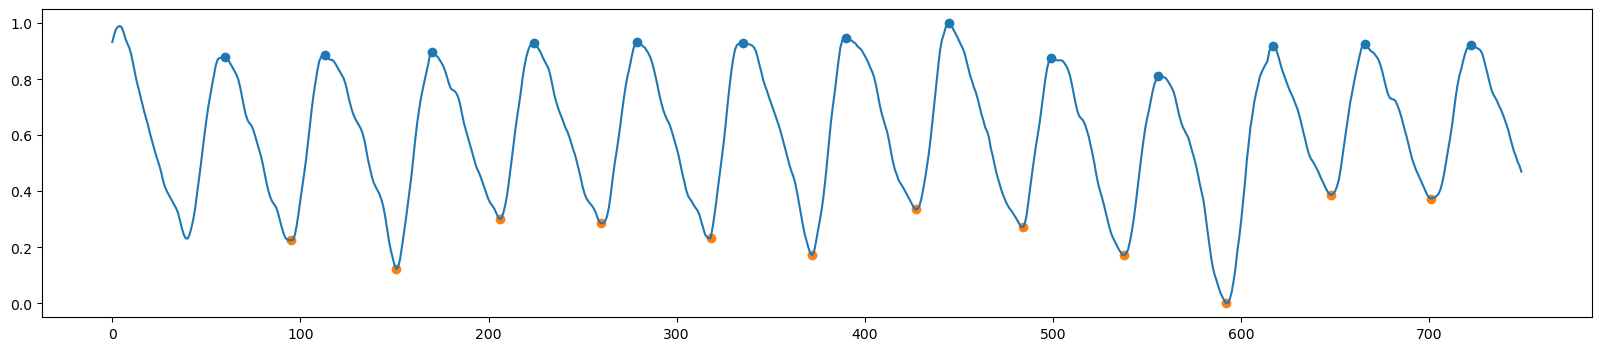

[53 57 54 55 56 55 55 54 57 61 49 56]
False


In [89]:
dataID = 12

d1 = data['PLETH'][dataID][2500:3250]
d2 = data['PLETH'][dataID][3250:]

PPG = d2
PPG = minmax_scale(PPG)
sig_length = len(PPG)
# Transpose the Signals if they are in column format, necessary for peak detection
if PPG.shape[0] > 1:
    PPG = PPG.T

try:
    wd_p, _ = hp.process(PPG, sample_rate=100) # peak 검출
except Exception:
    print('heartpy error')

# Peak
pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)

if pks_PPG[-1] == (sig_length-1):
    pks_PPG = np.delete(pks_PPG,-1)

P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])  # peak의 위치 리스트

if all(np.gradient(PPG[-3:])>=0):
    val_PPG = np.concatenate([val_PPG, [np.argmin(PPG[pks_PPG[-1]:len(PPG)])+pks_PPG[-1]]], axis=-1)



peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std, feature 1
std_peaks_PPG = np.std(PPG[pks_PPG]) # peak 값의 std, feature 2
max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
differ_pks = get_difference_list(PPG[pks_PPG])
max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

print('std_peak_dist_PPG:',std_peak_dist_PPG) # 10
print('std_peaks_PPG:',std_peaks_PPG) # 0.1
print('max_min_differ_pks:',max_min_differ_pks) # 0.3
print('max_differ_pks:',max_differ_pks) # 0.2


valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
std_valley_PPG = np.std(PPG[val_PPG]) # valley 값의 std
num_valley_PPG = len(val_PPG) # valley 갯수
max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # 최대 valley와 최소 valley 차이, feature 4
differ_val = get_difference_list(PPG[val_PPG])
max_differ_val = max(np.abs(differ_val)) # valley간 차분값의 최댓값, feature 5



print('std_valley_dist_PPG:',std_valley_dist_PPG) # 10
print('std_valley_PPG:',std_valley_PPG) # 0.1
print('max_min_differ_val:',max_min_differ_val) # 0.3
print('max_differ_val:',max_differ_val) # 0.2


plt.figure(figsize=(20,4))
plt.plot(PPG)
plt.scatter(pks_PPG, PPG[pks_PPG])
plt.scatter(val_PPG, PPG[val_PPG])
plt.show()
print(get_difference_list(pks_PPG))
print(np.any(get_difference_list(pks_PPG)<5))

In [57]:
a=np.array([1,2,3,4,5])
np.any(a<2)

True